In [2]:
# Imported Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

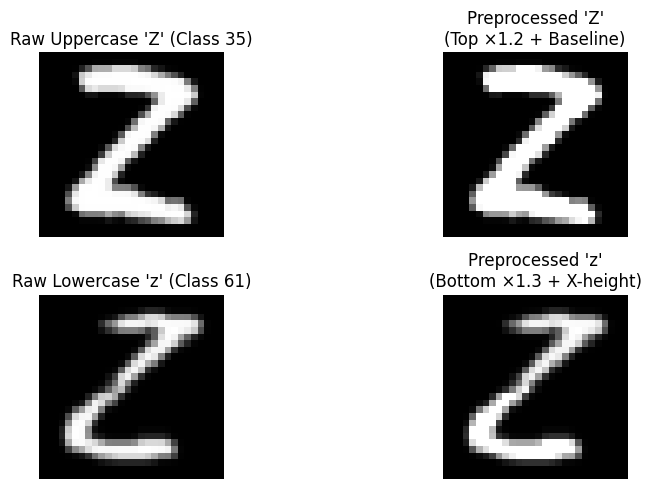

In [2]:
# 1. Enhanced Data Loading and Preprocessing (Your exact code)
def load_emnist(data_dir):
    def load_images(path):
        with open(path, 'rb') as f:
            _ = int.from_bytes(f.read(4), 'big')
            num_images = int.from_bytes(f.read(4), 'big')
            rows = int.from_bytes(f.read(4), 'big')
            cols = int.from_bytes(f.read(4), 'big')
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    
    def load_labels(path):
        with open(path, 'rb') as f:
            _ = int.from_bytes(f.read(4), 'big')
            num_labels = int.from_bytes(f.read(4), 'big')
            return np.frombuffer(f.read(), dtype=np.uint8)
    
    train_images = load_images(os.path.join(data_dir, 'emnist-byclass-train-images-idx3-ubyte'))
    train_labels = load_labels(os.path.join(data_dir, 'emnist-byclass-train-labels-idx1-ubyte'))
    
    train_images = np.transpose(train_images, (0, 2, 1)) / 255.0
    
    selected_indices = []
    for label in np.unique(train_labels):
        indices = np.where(train_labels == label)[0][:800]
        selected_indices.extend(indices)
    
    return train_images[selected_indices], train_labels[selected_indices]

def enhance_character_features(images, labels):
    """Special preprocessing for confusing character pairs"""
    enhanced_images = np.copy(images)
    label_indices = labels
    
    confusing_pairs = [
        (12,38), (15,41), (19,45), (20,46), (24,50),
        (28,54), (30,56), (31,57), (32,58), (33,59),
        (34,60), (35,61)  # C/c, F/f, J/j, K/k, O/o, S/s, U/u, V/v, W/w, X/x, Y/y, Z/z
    ]
    
    for upper, lower in confusing_pairs:
        upper_mask = (label_indices == upper)
        lower_mask = (label_indices == lower)
        
        # Uppercase processing - emphasize top regions
        enhanced_images[upper_mask] = np.clip(enhanced_images[upper_mask] * 1.2, 0, 1)
        for img in enhanced_images[upper_mask]:
            img[18:20,:] = np.maximum(img[18:20,:], 0.7)  # Baseline marker
            
        # Lowercase processing - emphasize bottom regions
        enhanced_images[lower_mask,14:,:] = np.clip(enhanced_images[lower_mask,14:,:] * 1.3, 0, 1)
        for img in enhanced_images[lower_mask]:
            # X-height marker
            img[10:12,5:23] = np.maximum(img[10:12,5:23], 0.4)  
    
    return enhanced_images

data_dir = '/kaggle/input/eminist/gzip'
images, labels = load_emnist(data_dir)
X = images.reshape(-1, 28, 28, 1)
X = enhance_character_features(X, labels)
y = to_categorical(labels, num_classes=62)

# Visualization of Z/z before and after preprocessing
# Get raw images (before preprocessing)
raw_images = images.reshape(-1, 28, 28, 1)

uppercase_Z_idx = np.where(labels == 35)[0][0]  # First sample
lowercase_z_idx = np.where(labels == 61)[0][0]  # First sample

# Create figure
plt.figure(figsize=(10, 5))

# Uppercase Z visualization
plt.subplot(2, 2, 1)
plt.imshow(raw_images[uppercase_Z_idx].squeeze(), cmap='gray')
plt.title("Raw Uppercase 'Z' (Class 35)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(X[uppercase_Z_idx].squeeze(), cmap='gray')
plt.title("Preprocessed 'Z'\n(Top ×1.2 + Baseline)")
plt.axis('off')

# Lowercase z visualization
plt.subplot(2, 2, 3)
plt.imshow(raw_images[lowercase_z_idx].squeeze(), cmap='gray')
plt.title("Raw Lowercase 'z' (Class 61)")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X[lowercase_z_idx].squeeze(), cmap='gray')
plt.title("Preprocessed 'z'\n(Bottom ×1.3 + X-height)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Just for the testing Phase too get all the Confusing Pairs

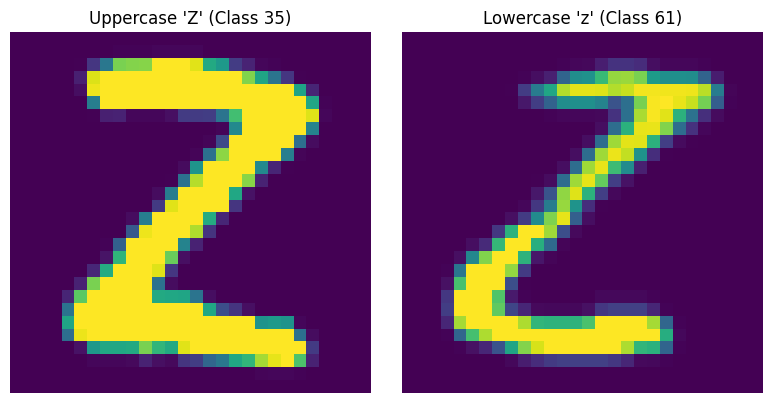

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Find indices of uppercase 'C' (class 12) and lowercase 'c' (class 38)
uppercase_C_indices = np.where(labels == 35)[0][:10]  # First 2 samples
lowercase_c_indices = np.where(labels == 61)[0][:10]  # First 2 samples

# Plot the images
plt.figure(figsize=(8, 4))

# Plot uppercase C
plt.subplot(1, 2, 1)
plt.imshow(X[uppercase_C_indices[0]].squeeze())
plt.title(f"Uppercase 'Z' (Class 35)")
plt.axis('off')

# Plot lowercase c
plt.subplot(1, 2, 2)
plt.imshow(X[lowercase_c_indices[0]].squeeze())
plt.title(f"Lowercase 'z' (Class 61)")
plt.axis('off')

plt.tight_layout()
plt.show()

# CNN Implementation

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import KFold

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(62, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# === Cross-Validation + Evaluation ===
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []

show_conf_matrices = False  # Set to True to show confusion matrices

print("Running 10-Fold Cross Validation with CNN...\n")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
    model = create_cnn_model()
    model.fit(X[train_idx], y[train_idx], batch_size=128, epochs=15, verbose=0)
    
    y_pred = model.predict(X[val_idx])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y[val_idx], axis=1)
    
    acc = accuracy_score(y_true_classes, y_pred_classes)
    prec = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
    rec = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    print(f"Fold {fold}: Accuracy = {acc*100:.2f}%, Precision = {prec:.4f}, Recall = {rec:.4f}, F1-Score = {f1:.4f}")
    


# === Final Results Summary ===
print("\nFinal 10-Fold Evaluation Results:")
print(f"Average Accuracy     : {np.mean(accuracies)*100:.2f}%")
print(f"Average Precision    : {np.mean(precisions):.4f}")
print(f"Average Recall       : {np.mean(recalls):.4f}")
print(f"Average F1-Score     : {np.mean(f1_scores):.4f}")
print(f"Accuracy Std Dev     : ±{np.std(accuracies)*100:.2f}%")


Running 10-Fold Cross Validation with CNN...



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 1: Accuracy = 87.12%, Precision = 0.8755, Recall = 0.8729, F1-Score = 0.8697


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2: Accuracy = 87.48%, Precision = 0.8762, Recall = 0.8707, F1-Score = 0.8664


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3: Accuracy = 87.26%, Precision = 0.8733, Recall = 0.8734, F1-Score = 0.8688


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4: Accuracy = 86.03%, Precision = 0.8703, Recall = 0.8623, F1-Score = 0.8545


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5: Accuracy = 87.20%, Precision = 0.8743, Recall = 0.8699, F1-Score = 0.8658


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 6: Accuracy = 85.48%, Precision = 0.8596, Recall = 0.8574, F1-Score = 0.8521


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 7: Accuracy = 87.18%, Precision = 0.8769, Recall = 0.8720, F1-Score = 0.8677


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 8: Accuracy = 87.12%, Precision = 0.8768, Recall = 0.8745, F1-Score = 0.8702


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 9: Accuracy = 86.77%, Precision = 0.8729, Recall = 0.8669, F1-Score = 0.8597


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 10: Accuracy = 88.29%, Precision = 0.8826, Recall = 0.8800, F1-Score = 0.8769

Final 10-Fold Evaluation Results:
Average Accuracy     : 86.99%
Average Precision    : 0.8738
Average Recall       : 0.8700
Average F1-Score     : 0.8652
Accuracy Std Dev     : ±0.73%


# Deep Capsule Network Implementation

In [3]:
def squash(vectors, axis=-1):
    """
    Applies the squash function to input vectors. 
    The squash function ensures that the magnitude of each vector lies between 0 and 1, 
    while preserving its direction. This is a critical part of the Capsule Networks 
    to ensure that the output vectors are normalized.
    """
    
    # Step 1: Compute the squared L2 norm of the vectors along the specified axis.
    # This calculates the sum of the squares of the vector components.
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)

    # Step 2: Calculate the scaling factor for the squash function.
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)

    # Step 3: Scale the input vectors by the computed scale factor.
    # This operation modifies the magnitude of the vectors while preserving their direction.
    return scale * vectors

In [4]:
def PrimaryCap2D(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Creates a Primary Capsule layer in 2D using convolution and reshaping.
    This layer is typically the first capsule layer in a Capsule Network.

    Parameters:
        inputs (Tensor): Input tensor, usually the output of a feature extraction layer.
        dim_capsule (int): The dimensionality of each capsule vector.
        n_channels (int): The number of capsule channels.
        kernel_size (int): The size of the convolution kernel.
        strides (int): The stride of the convolution.
        padding (str): Padding type for convolution.
    """

    # Step 1: Apply a 2D convolution to the input tensor.
    # This extracts features and prepares them for grouping into capsules.
    output = layers.Conv2D(
        filters=dim_capsule * n_channels, 
        kernel_size=kernel_size, 
        strides=strides,
        kernel_initializer='he_normal',
        padding=padding, 
        name='primarycap_conv2d'
    )(inputs)

    # Step 2: Reshape the convolution output into a tensor of capsules.
    # The target shape is (-1, dim_capsule), where:
    # - `-1` lets TensorFlow automatically calculate the appropriate size for the batch dimension.
    # - `dim_capsule` represents the dimensionality of each capsule vector.
    outputs = layers.Reshape(
        target_shape=[-1, dim_capsule], 
        name='primarycap_reshape'
    )(output)

    # Step 3: Apply the squash function to normalize the capsule vectors.
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [5]:
class CapsuleLayer(layers.Layer):
    """
    A Capsule Layer that implements dynamic routing between capsules.

    Parameters:
        num_capsule (int): Number of capsules in the output layer.
        dim_capsule (int): Dimensionality of each output capsule vector.
        routings (int): Number of routing iterations.
        kernel_initializer (str): Initializer for the weight matrix.
        **kwargs: Additional keyword arguments for the parent Layer class.
    """
    
    def __init__(self, num_capsule, dim_capsule, routings, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        """
        Build the layer's weight matrix based on the input shape.

        Parameters:
            input_shape (tuple): Shape of the input tensor (batch_size, input_num_capsule, input_dim_capsule).
        """
        
        # Number of input capsules and their dimensions
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Weight matrix W for transformation between input and output capsules
        # Shape: [num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        self.W = self.add_weight(
            shape=[self.num_capsule, self.input_num_capsule, self.dim_capsule, self.input_dim_capsule],
            initializer=self.kernel_initializer,
            name='W'
        )

        # Mark the layer as built
        self.built = True

    def call(self, inputs, training=None):
        """
        Perform the forward pass with dynamic routing.

        Parameters:
            inputs (Tensor): Input tensor of shape (batch_size, input_num_capsule, input_dim_capsule).
            training (bool): Training mode indicator (default is None).
        """

        inputs = tf.ensure_shape(inputs, [64, 512, 8])

        # Expand dimensions to prepare for tiling
        # Shape after expansion: [batch_size, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Tile the inputs to match the number of output capsules
        # Shape after tiling: [batch_size, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Perform the transformation using the weight matrix W
        # Shape after transformation: [batch_size, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(
            tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)
        )

        # Initialize the coupling coefficients
        # Shape: [batch_size, num_capsule, 1, input_num_capsule]
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.num_capsule, 1, self.input_num_capsule])

        # Routing algorithm
        for i in range(self.routings):
            # Compute softmax over coupling coefficients
            # Shape: [batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # Weighted sum of input predictions
            # Shape: [batch_size, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))

            # Update coupling coefficients based on agreement
            if i < self.routings - 1:
                # Update b for the next iteration
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)

        # Return the output capsules, squeezed to remove unnecessary dimensions
        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

In [6]:
class Length(layers.Layer):
    """
    Compute the length (Euclidean norm) of vectors in a tensor.

    Use case:
    - Interpret vector lengths as probabilities for multi-class predictions.

    Inputs:
        - shape: [batch size, num vectors, dim vector]

    Outputs:
        - shape: [batch size, num vectors]
    """

    def call(self, inputs, **kwargs):
        """
        Forward pass of the layer.

        Parameters:
            inputs (tensor): A tensor of shape [batch size, num vectors, dim vector].
        """
        # Compute the Euclidean norm (length) of vectors
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config

In [7]:
class Mask(layers.Layer):
    """
    Mask Layer for Capsule Networks.

    Masks capsule outputs based on:
    1. Provided true labels (supervised).
    2. Capsule with maximum length (unsupervised).
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])

In [8]:
def CapsNet2D(input_shape, n_class, routings):
    """
    Builds a 2D Capsule Network.
    
    Parameters:
        input_shape (tuple): Shape of the input data (e.g., (28, 28, 1)).
        n_class (int): Number of classes for classification.
        routings (int): Number of routing iterations for the CapsuleLayer.

    Returns:
        train_model (tf.keras.Model): Model for training with reconstruction loss.
    """

    # Input layer 1: Accepts input data of the specified shape
    inputs = layers.Input(shape=input_shape, batch_size = 64, name='input_layer')

    # Layer 2
    conv1 = layers.Conv2D(32, kernel_size=(5, 5), kernel_initializer='he_normal', strides=1, padding='valid', activation=LeakyReLU(alpha=0.1), name='conv1_layer')(inputs)
    
    # Layer 3
    conv2 = layers.Conv2D(32, kernel_size=(5, 5), kernel_initializer='he_normal', strides=1, padding='valid', activation=LeakyReLU(alpha=0.1), name='conv2_layer')(conv1)
    
    # Layer 4
    conv3 = layers.Conv2D(128, kernel_size=(5, 5), kernel_initializer='he_normal', strides=1, padding='valid', activation=LeakyReLU(alpha=0.1), name='conv3_layer')(conv2)
    
    # Layer 5
    conv4 = layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_normal', strides=1, padding='valid', activation=LeakyReLU(alpha=0.1), name='conv4_layer')(conv3)
    
    # Layer 6
    conv5 = layers.Conv2D(256, kernel_size=(3, 3), kernel_initializer='he_normal', strides=1, padding='valid', activation=LeakyReLU(alpha=0.1), name='conv5_layer')(conv4)

    # Layer 7: Primary Capsule layer to create capsules from convolutional features
    primary_caps = PrimaryCap2D(conv5, dim_capsule=8, n_channels=32, 
                                kernel_size=(5, 5), strides=2, padding='valid')

    # Layer 8: Digit Capsule layer to represent class-specific capsules
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, 
                             routings=routings, name='digit_capsule_layer')(primary_caps)
    
    # Compute the length of each capsule as the output probabilities
    out_caps = Length(name='capsnet')(digitcaps)

    # Layer 9: Masking mechanism for reconstruction
    # Mask capsules using the provided labels
    y = layers.Input(shape=(n_class,), name='label_input')  # True labels input
    masked_by_y = Mask()([digitcaps, y])

    # Decoder: Reconstruct input data from the capsule representations
    decoder = layers.Dense(512, kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.1))(masked_by_y)  # Fully connected layer
    decoder = layers.Dense(1024, kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.1))(decoder)  # Fully connected layer
    decoder = layers.Dense(np.prod(input_shape), activation='softmax')(decoder)  # Output layer
    decoder = layers.Reshape(target_shape=input_shape, name='out_recon')(decoder)  # Reshape to input shape

    # Training model: Includes capsule output and reconstruction loss
    train_model = models.Model(inputs=[inputs, y], 
                                outputs=[out_caps, decoder])

    return train_model

input_shape = (28, 28, 1)
n_class = 62            # Number of classes
routings = 3           # Number of routing iterations

# Build the training and evaluation models
model = CapsNet2D(input_shape, n_class, routings)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (64, 28, 28, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_layer (Conv2D)      │ (64, 24, 24, 32)       │            832 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_layer (Conv2D)      │ (64, 20, 20, 32)       │         25,632 │ conv1_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3_layer (Conv2D)      │ (64, 16, 16, 128)      │        102,528 │ conv2_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv4_layer (Conv2D)      │ (64, 14, 14, 128)      │        147,584 │ conv3_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv5_layer (Conv2D)      │ (64, 12, 12, 256)      │        295,168 │ conv4_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ primarycap_conv2d         │ (64, 4, 4, 256)        │      1,638,656 │ conv5_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ primarycap_reshape        │ (64, 512, 8)           │              0 │ primarycap_conv2d[0][… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ primarycap_squash         │ (64, 512, 8)           │              0 │ primarycap_reshape[0]… │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ digit_capsule_layer       │ (None, 62, 16)         │      4,063,232 │ primarycap_squash[0][… │
│ (CapsuleLayer)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_input (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask (Mask)               │ (None, 16)             │              0 │ digit_capsule_layer[0… │
│                           │                        │                │ label_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │          8,704 │ mask[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │        525,312 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 784)            │        803,600 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ capsnet (Length)          │ (None, 62)             │              0 │ digit_capsule_layer[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_recon (Reshape)       │ (None, 28, 28, 1)      │              0 │ dense_2[0][0]          │
└──────────────────────

 Total params: 7,611,248 (29.03 MB)

 Trainable params: 7,611,248 (29.03 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def margin_loss(y_true, y_pred):
    """
    Computes the margin loss.
    
    Parameters:
        y_true: Tensor of shape [batch_size, n_classes], one-hot encoded true labels.
        y_pred: Tensor of shape [batch_size, n_classes], predicted probabilities (length of capsules).
    
    Returns:
        A scalar loss value computed across the batch.
    """
    # Calculate the loss for positive classes (y_true == 1)
    # Encourages the predicted probability to be close to 0.9
    positive_loss = y_true * tf.square(tf.maximum(0., 0.9 - y_pred))
    
    # Calculate the loss for negative classes (y_true == 0)
    # Encourages the predicted probability to be close to 0.1
    negative_loss = 0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    
    # Combine the positive and negative losses
    L = positive_loss + negative_loss
    
    # Compute the total loss as the sum of losses across all classes for each sample,
    # followed by the mean across the batch
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [11]:
from tensorflow.keras import backend as K
import gc
# Apply 10-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store evaluation results
all_fold_accuracies = []
all_fold_losses = []
all_fold_precisions = []
all_fold_recalls = []
all_fold_f1_scores = []
fold = 0

for train_idx, val_idx in kf.split(X, labels):  
    X_train, X_test = X[train_idx], X[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=[margin_loss, 'mse'],
        loss_weights=[1.0, 0.0005],
        metrics={'capsnet': 'accuracy'}
    )
    
    # Ensure training data is divisible by batch size
    num_batches = len(X_train) // 64
    X_train = X_train[:num_batches * 64]
    y_train = y_train[:num_batches * 64]
    
    num_batches_val = len(X_test) // 64
    X_test = X_test[:num_batches_val * 64]
    y_test = y_test[:num_batches_val * 64]
    
    # Train the model
    model.fit(
        x=[X_train, y_train],
        y=[y_train, X_train],
        epochs=10,
        batch_size=64,
        validation_data=([X_test, y_test], [y_test, X_test])
    )
    
    # **Evaluate the model on the test set**
    evaluation_results = model.evaluate(
        x=[X_test, y_test],  # Test input data
        y=[y_test, X_test],  # Test target data
        batch_size=64  # Use the same batch size as during training
    )
    
    # Unpack results
    total_loss = evaluation_results[0]
    capsnet_loss = evaluation_results[1]
    reconstruction_loss = evaluation_results[2]
    capsnet_accuracy = evaluation_results[3]
    
    # Predict classes for precision, recall, and f1 calculation
    y_pred = model.predict([X_test, y_test], batch_size= 64)  # set batch size to 64
    y_pred_classes = np.argmax(y_pred[0], axis=1)  # Predicted class labels (CapsNet output)
    y_true_classes = np.argmax(y_test, axis=1)     # True class labels
    
    # Compute precision, recall, and F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Store results
    all_fold_accuracies.append(capsnet_accuracy)
    all_fold_losses.append(total_loss)
    all_fold_precisions.append(precision)
    all_fold_recalls.append(recall)
    all_fold_f1_scores.append(f1)
    
    # Print Fold Results
    print(f"Fold {fold + 1} Results:")
    fold = fold + 1
    print(f"Total Loss: {total_loss:.4f}")
    print(f"CapsNet Loss: {capsnet_loss:.4f}")
    print(f"Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"CapsNet Accuracy: {capsnet_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("=" * 50)


    K.clear_session()  # Clear current TF graph
    gc.collect()       # Python garbage collection

# Final Evaluation: Average Metrics Across All Folds
average_accuracy_DCN = np.mean(all_fold_accuracies)
average_loss_DCN = np.mean(all_fold_losses)
average_precision_DCN = np.mean(all_fold_precisions)
average_recall_DCN = np.mean(all_fold_recalls)
average_f1_DCN = np.mean(all_fold_f1_scores)

print(f"Final 10-Fold Results:")
print(f"Average Total Loss: {average_loss_DCN:.4f}")
print(f"Average CapsNet Accuracy: {average_accuracy_DCN:.4f}")
print(f"Average Precision: {average_precision_DCN:.4f}")
print(f"Average Recall: {average_recall_DCN:.4f}")
print(f"Average F1-Score: {average_f1_DCN:.4f}")

# Save the entire model (architecture + weights + optimizer state)
model.save('capsnet_emnist_full_model (1).keras')  # Recommended (.keras format)
# OR (older format)
# model.save('capsnet_emnist_full_model.h5')  

print("Full model saved successfully!")


Epoch 1/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - capsnet_accuracy: 0.9085 - capsnet_loss: 0.0714 - loss: 0.0715 - out_recon_loss: 7.4255e-05 - val_capsnet_accuracy: 0.8592 - val_capsnet_loss: 0.1080 - val_loss: 0.1081 - val_out_recon_loss: 7.3598e-05
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - capsnet_accuracy: 0.9171 - capsnet_loss: 0.0643 - loss: 0.0644 - out_recon_loss: 7.3868e-05 - val_capsnet_accuracy: 0.8517 - val_capsnet_loss: 0.1137 - val_loss: 0.1138 - val_out_recon_loss: 7.3566e-05
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - capsnet_accuracy: 0.9231 - capsnet_loss: 0.0615 - loss: 0.0615 - out_recon_loss: 7.3817e-05 - val_capsnet_accuracy: 0.8628 - val_capsnet_loss: 0.1042 - val_loss: 0.1042 - val_out_recon_loss: 7.3538e-05
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - capsnet_accuracy: 0.9320 - capsnet_loss: 0.0543 - loss: 0.0543 - out_recon_loss: 7.3914e-05 - val_capsnet_accuracy: 0.8630 - val_capsnet_loss: 0.1064 - val_loss: 0.1065 -

# Comparison Between CNN and Deep Capsule Network 


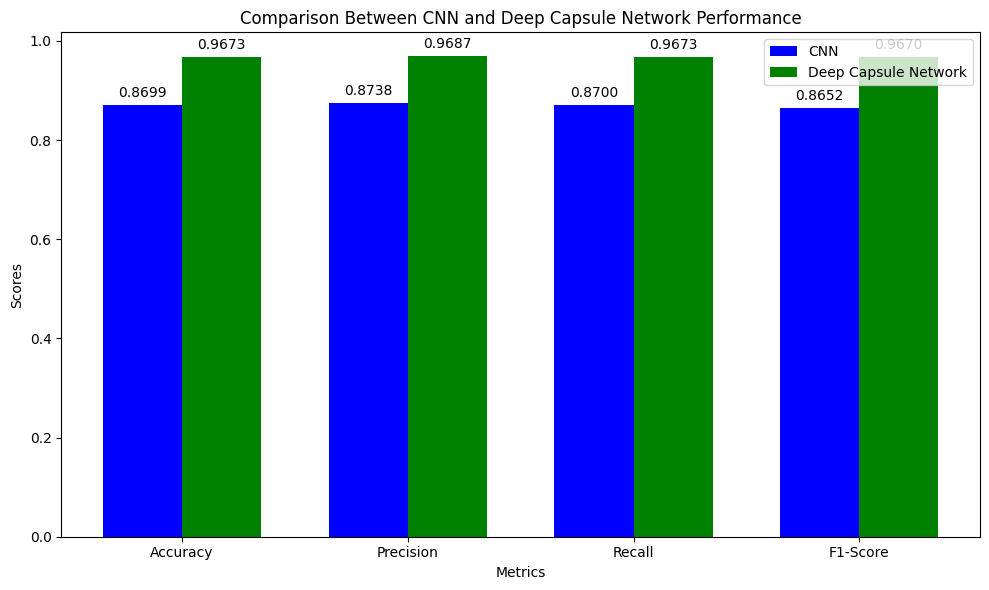

In [16]:
# Deep Capsule Network Results
dcn_accuracy = average_accuracy_DCN
dcn_precision = average_precision_DCN
dcn_recall = average_recall_DCN
dcn_f1_score = average_f1_DCN

# CNN Model Results - Averaging Each Metric Up To 4 Decimal Places
cnn_accuracy = round(np.mean(accuracies), 4)
cnn_precision = round(np.mean(precisions), 4)
cnn_recall = round(np.mean(recalls), 4)
cnn_f1_score = round(np.mean(f1_scores), 4)

# Metrics for Plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cnn_values = [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1_score]
dcn_values = [round(dcn_accuracy, 4), round(dcn_precision, 4), round(dcn_recall, 4), round(dcn_f1_score, 4)]

bar_width = 0.35
index = np.arange(len(metrics))
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for CNN and DCN
bar1 = ax.bar(index, cnn_values, bar_width, label='CNN', color='b')
bar2 = ax.bar(index + bar_width, dcn_values, bar_width, label='Deep Capsule Network', color='g')

# Annotate Bars with Values
for i in range(len(metrics)):
    ax.text(index[i], cnn_values[i] + 0.01, f'{cnn_values[i]:.4f}', ha='center', va='bottom', fontsize=10, color='black')
    ax.text(index[i] + bar_width, dcn_values[i] + 0.01, f'{dcn_values[i]:.4f}', ha='center', va='bottom', fontsize=10, color='black')

# Labels and Title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison Between CNN and Deep Capsule Network Performance')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


# Checking Accuracy on Test Data

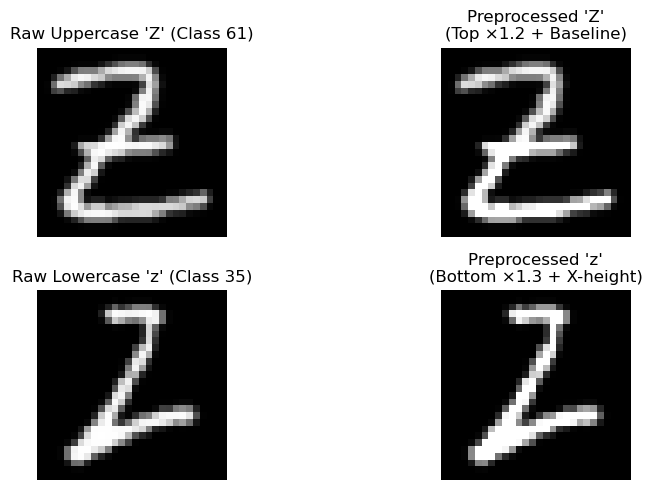

In [32]:
# 1. Load EMNIST from .gz files
def load_emnist(data_dir):
    def load_images(path):
        with gzip.open(path, 'rb') as f:
            _ = int.from_bytes(f.read(4), 'big')
            num_images = int.from_bytes(f.read(4), 'big')
            rows = int.from_bytes(f.read(4), 'big')
            cols = int.from_bytes(f.read(4), 'big')
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)

    def load_labels(path):
        with gzip.open(path, 'rb') as f:
            _ = int.from_bytes(f.read(4), 'big')
            num_labels = int.from_bytes(f.read(4), 'big')
            return np.frombuffer(f.read(), dtype=np.uint8)

    train_images = load_images(os.path.join(data_dir, 'emnist-byclass-train-images-idx3-ubyte.gz'))
    train_labels = load_labels(os.path.join(data_dir, 'emnist-byclass-train-labels-idx1-ubyte.gz'))

    train_images = np.transpose(train_images, (0, 2, 1)) / 255.0

    # Subsample max 800 per class
    selected_indices = []
    for label in np.unique(train_labels):
        indices = np.where(train_labels == label)[0][800:1000]
        selected_indices.extend(indices)

    return train_images[selected_indices], train_labels[selected_indices]

# 2. Enhance confusing characters (e.g., Z/z)
def enhance_character_features(images, labels):
    enhanced_images = np.copy(images)
    label_indices = labels

    confusing_pairs = [
        (12, 38), (15, 41), (19, 45), (20, 46), (24, 50),
        (28, 54), (30, 56), (31, 57), (32, 58), (33, 59),
        (34, 60), (35, 61)  # C/c, F/f, J/j, K/k, O/o, S/s, U/u, V/v, W/w, X/x, Y/y, Z/z
    ]

    for upper, lower in confusing_pairs:
        upper_mask = (label_indices == upper)
        lower_mask = (label_indices == lower)

        enhanced_images[upper_mask] = np.clip(enhanced_images[upper_mask] * 1.2, 0, 1)
        for img in enhanced_images[upper_mask]:
            img[18:20, :] = np.maximum(img[18:20, :], 0.7)  # Upper marker

        enhanced_images[lower_mask, 14:, :] = np.clip(enhanced_images[lower_mask, 14:, :] * 1.3, 0, 1)
        for img in enhanced_images[lower_mask]:
            img[10:12, 5:23] = np.maximum(img[10:12, 5:23], 0.4)  # Lower marker

    return enhanced_images

# 3. Load + preprocess
data_dir = r"D:\Studies Material\OLA Project\EMNIST"
images, labels = load_emnist(data_dir)
X = images.reshape(-1, 28, 28, 1)
X = enhance_character_features(X, labels)
y = to_categorical(labels, num_classes=62)

# 4. Visualization of uppercase vs lowercase Z
raw_images = images.reshape(-1, 28, 28, 1)
uppercase_Z_idx = np.where(labels == 61)[0][0]
lowercase_z_idx = np.where(labels == 35)[0][0]

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(raw_images[uppercase_Z_idx].squeeze(), cmap='gray')
plt.title("Raw Uppercase 'Z' (Class 61)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(X[uppercase_Z_idx].squeeze(), cmap='gray')
plt.title("Preprocessed 'Z'\n(Top ×1.2 + Baseline)")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(raw_images[lowercase_z_idx].squeeze(), cmap='gray')
plt.title("Raw Lowercase 'z' (Class 35)")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X[lowercase_z_idx].squeeze(), cmap='gray')
plt.title("Preprocessed 'z'\n(Bottom ×1.3 + X-height)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
# Trim test data to be divisible by 64
n = (X.shape[0] // 64) * 64
X_trimmed = X[:n]
y_trimmed = y[:n]

# Run predictions
y_pred_logits, _ = model.predict([X_trimmed, y_trimmed], batch_size=64)

# Get labels
y_true_labels = np.argmax(y_trimmed, axis=1)
y_pred_labels = np.argmax(y_pred_logits, axis=1)

# Accuracy
test_accuracy = np.mean(y_true_labels == y_pred_labels)
print(f"Test Accuracy on {n} trimmed samples: {test_accuracy:.4f}")

C:\Users\manna\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'label_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 38s 187ms/step
Test Accuracy on 12352 trimmed samples: 0.8677
